In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.spatial.transform import Rotation as R
import sympy as sp
from sympy.physics.quantum.spin import Rotation as WignerRotation

# --- Step 1: Simulate vector trajectory on a cone ---
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)
    phi = 0.0
    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vectors[i] = np.array([x, y, z])
    return vectors

# --- Step 2: Compute spherical harmonic time series ---
def compute_Ylm_series(vectors, l=2):
    theta = np.arccos(vectors[:, 2])
    phi = np.arctan2(vectors[:, 1], vectors[:, 0])
    Y_series = {}
    for m in range(-l, l + 1):
        Y_series[m] = sph_harm(m, l, phi, theta)
    return Y_series

# --- Step 3: Compute C_{l,m,m'}(t) matrix ---
def compute_correlation_matrix(Y_series, max_lag=1000):
    l = max(Y_series.keys())
    corr_matrix = {}
    for m1 in range(-l, l + 1):
        for m2 in range(-l, l + 1):
            corr = []
            y1 = Y_series[m1]
            y2 = Y_series[m2]
            for tau in range(max_lag):
                val = np.mean(y1[:-tau or None] * np.conj(y2[tau:])) if tau > 0 else np.mean(y1 * np.conj(y2))
                corr.append(val)
            corr_matrix[(m1, m2)] = np.array(corr)
    return corr_matrix

# --- Step 4: Construct Wigner D-matrix ---
#from scipy.special import wignerd

def wigner_d_matrix(l, alpha, beta, gamma):
    """
    Compute Wigner D-matrix D^l_{m', m}(alpha, beta, gamma)
    without using scipy.special
    """
    m_vals = np.arange(-l, l+1)
    D = np.zeros((2*l+1, 2*l+1), dtype=complex)

    def little_d(l, mp, m, beta):
        """Compute small-d matrix element d^l_{mp,m}(beta)"""
        sum_k = 0
        kmin = max(0, m - mp)
        kmax = min(l + m, l - mp)
        for k in range(kmin, kmax + 1):
            num = ((-1)**k *
                   np.sqrt(fact(l + mp) * fact(l - mp) * fact(l + m) * fact(l - m)))
            denom = (fact(l + m - k) * fact(l - mp - k) * fact(k) * fact(k + mp - m))
            term = (num / denom *
                    (np.cos(beta / 2) ** (2 * l + m - mp - 2 * k)) *
                    (np.sin(beta / 2) ** (2 * k + mp - m)))
            sum_k += term
        return sum_k

    for i, mp in enumerate(m_vals):
        for j, m in enumerate(m_vals):
            d = little_d(l, mp, m, beta)
            D[i, j] = np.exp(-1j * mp * alpha) * d * np.exp(-1j * m * gamma)

    return D




def rotate_correlation_matrix(corr_matrix, l, D):
    """
    Rotate the full correlation matrix using Wigner D-matrix.
    corr_matrix[(m1, m2)] is a function of time.
    D is a (2l+1)x(2l+1) Wigner D-matrix.
    Returns the rotated correlation function C'_m(t) for each m.
    """
    m_vals = np.arange(-l, l + 1)
    corr_rotated = {}

    # Step 1: Construct original correlation matrix as a 3D array
    # Shape: (2l+1, 2l+1, T) where T is length of time array
    T = next(iter(corr_matrix.values())).shape[0]
    Cmat = np.zeros((2*l+1, 2*l+1, T), dtype=complex)
    for i, m1 in enumerate(m_vals):
        for j, m2 in enumerate(m_vals):
            Cmat[i, j, :] = corr_matrix[(m1, m2)]

    # Step 2: Rotate correlation matrix using D
    # D * Cmat * D†
    C_rotated = np.einsum('im,mn...,jn->ij...', D, Cmat, D.conj())

    # Step 3: Extract only the diagonal elements (C'_m(t))
    for i, m in enumerate(m_vals):
        corr_rotated[m] = C_rotated[i, i, :]

    return corr_rotated




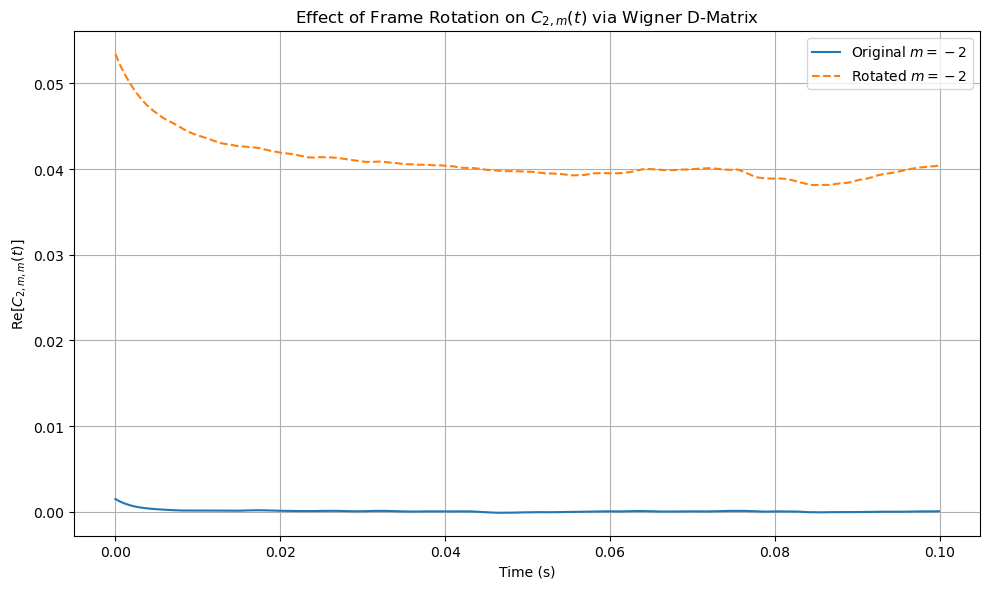

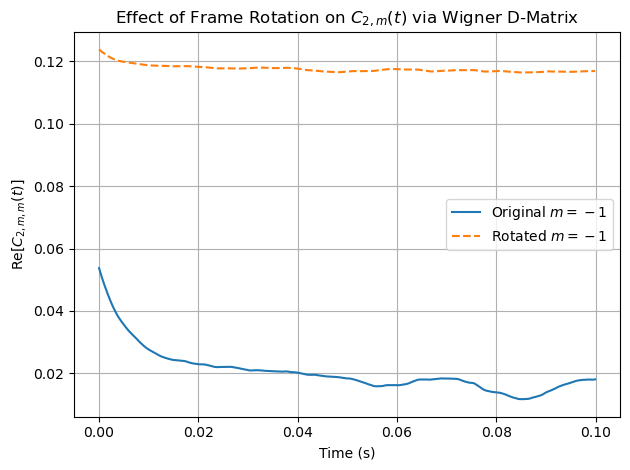

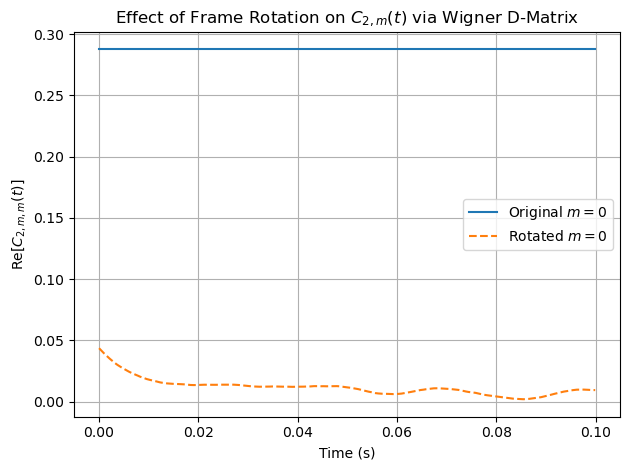

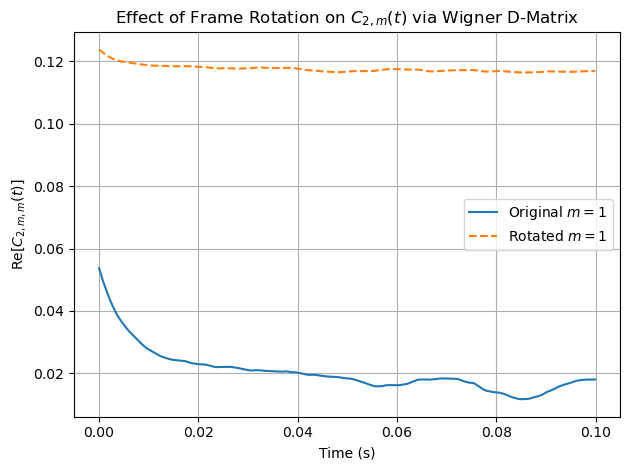

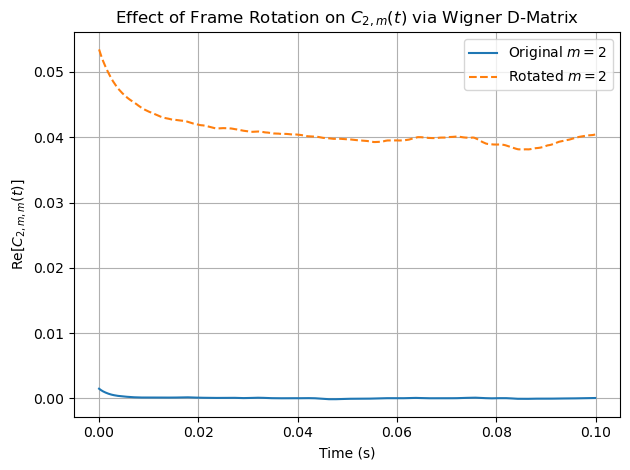

In [29]:
l = 2
dt = 1e-4
vectors = simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=dt)
Y_series = compute_Ylm_series(vectors, l=l)
corr_matrix = compute_correlation_matrix(Y_series)

# Get Euler angles from rotation (e.g., 45 degrees around x-axis)
rot = R.from_euler('x', 45, degrees=True)
alpha, beta, gamma = rot.as_euler('zyz')  # Convert to zyz Euler angles
D = wigner_d_matrix(2,alpha, beta, gamma)
corr_rotated = rotate_correlation_matrix(corr_matrix, l, D)

# Plot comparison of original vs rotated C_{2,m}(t)
t = np.arange(len(next(iter(corr_matrix.values())))) * dt
plt.figure(figsize=(10, 6))
for m in [-2, -1, 0, 1, 2]:
    plt.plot(t, np.real(corr_matrix[(m, m)]), label=fr'Original $m={m}$', linestyle='-')
    plt.plot(t, np.real(corr_rotated[m]), label=fr'Rotated $m={m}$', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel(r"$\mathrm{Re}[C_{2,m,m}(t)]$")
    plt.title("Effect of Frame Rotation on $C_{2,m}(t)$ via Wigner D-Matrix")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [30]:
# check the correctness of such transoformation
# --- Step 6: Calculate correlation function for a cone with axis rotated along x-axis by 45 degrees ---
# This is a simplified example to illustrate the transformation of the correlation function
def compute_cone_correlation(S2, tau_c, dt, num_steps=10000):
    # Simulate vector trajectory on a cone
    vectors = simulate_vector_on_cone(S2=S2, tau_c=tau_c, dt=dt, num_steps=num_steps)
    
    # Compute spherical harmonic series
    Y_series = compute_Ylm_series(vectors, l=2)
    
    # Compute correlation matrix
    corr_matrix = compute_correlation_matrix(Y_series)
    
    # Get Euler angles from rotation (e.g., 45 degrees around x-axis)
    rot = R.from_euler('x', 45, degrees=True)
    alpha, beta, gamma = rot.as_euler('zyz')  # Convert to zyz Euler angles
    D = wigner_d_matrix(2,alpha, beta, gamma)
    
    # Rotate correlation matrix
    corr_rotated = rotate_correlation_matrix(corr_matrix, l=2, D=D)
    
    return corr_rotated
# calcualte correlation function for a cone with axi rotated along x axis by 45 degrees
corr_rotated_cone = compute_cone_correlation(S2=0.85, tau_c=0.01, dt=1e-4)

# now directly calculate the correlation function for a cone with axis rotated along x-axis by 45 degrees

def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000, axis=np.array([0, 0, 1])):
    """
    Simulate a unit vector hopping on a cone surface with fixed S2 and correlation time tau_c.
    
    Returns:
        vectors: (num_steps, 3) array of unit vectors
    """
    # Cone angle from S²
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)

    # Ornstein-Uhlenbeck parameters for azimuthal diffusion
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)  # Unit noise strength
    phi = 0.0
    axis = axis / np.linalg.norm(axis)

    # Rotation matrix to align cone with axis
    R_align = rotation_matrix_from_vectors(np.array([0, 0, 1]), axis)

    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        # Update azimuthal angle using Ornstein-Uhlenbeck process
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi

        # Point on cone with fixed θ and current φ
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vec_local = np.array([x, y, z])

        # Rotate to align cone with specified axis
        vec_global = R_align @ vec_local
        vectors[i] = vec_global

    return vectors

def rotation_matrix_from_vectors(a, b):
    """Find the rotation matrix that aligns vector a to vector b"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    v = np.cross(a, b)
    c = np.dot(a, b)
    if c == 1:
        return np.eye(3)
    if c == -1:
        # 180° rotation around arbitrary perpendicular axis
        perp = np.array([1, 0, 0]) if not np.allclose(a, [1, 0, 0]) else np.array([0, 1, 0])
        return rotation_matrix_from_vectors(a, np.cross(a, perp))
    s = np.linalg.norm(v)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    return np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))

from scipy.special import sph_harm

def compute_sph_harm_autocorrelation(vectors, l=2, m=0):
    """
    Compute complex autocorrelation of Y_l^m spherical harmonics from vector trajectory.
    
    Parameters:
        vectors: (num_steps, 3) array of unit vectors
        l: degree of spherical harmonics
        m: order of spherical harmonics

    Returns:
        corr: autocorrelation values
    """
    N = len(vectors)
    theta = np.arccos(vectors[:, 2])  # z = cos(theta)
    phi = np.arctan2(vectors[:, 1], vectors[:, 0])  # arctangent of y/x

    Y_vals = sph_harm(m, l, phi, theta)

    corr = []
    for tau in range(N // 10):
        if tau == 0:
            c = np.abs(np.mean(Y_vals * np.conj(Y_vals)))  # Normalization
        else:
            c = np.mean(Y_vals[:-tau] * np.conj(Y_vals[tau:]))
        corr.append(np.real(c))  # or keep complex values
    return np.array(corr)



In [23]:
vecs = simulate_vector_on_cone(S2=0.85, tau_c=0.01, axis=np.array([0, -np.sqrt(2)/2, np.sqrt(2)/2]))
C_t_1 = compute_sph_harm_autocorrelation(vecs, l=2, m=1)
C_t_m1 = compute_sph_harm_autocorrelation(vecs, l=2, m=-1)
C_t_m2 = compute_sph_harm_autocorrelation(vecs, l=2, m=-2)
C_t_2 = compute_sph_harm_autocorrelation(vecs, l=2, m=2)
c_t_0 = compute_sph_harm_autocorrelation(vecs, l=2, m=0)
C_t_sum = 4*np.pi/5*(
    C_t_2 + C_t_1 + C_t_m1 + C_t_m2 + c_t_0
)

Text(0, 0.5, 'correlation function $C_{2,m}(t)$')

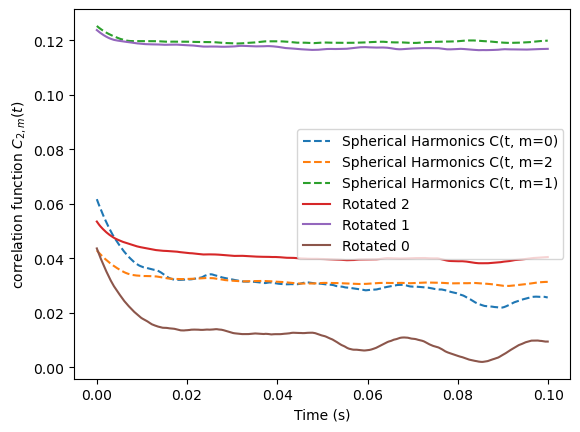

In [38]:
# plot the results to show consistency between two methods

time = np.arange(len(c_t_0)) * 1e-4

plt.plot(time, c_t_0, label='Spherical Harmonics C(t, m=0)', linestyle='--')
plt.plot(time, C_t_2, label='Spherical Harmonics C(t, m=2', linestyle='--')
plt.plot(time, C_t_1, label='Spherical Harmonics C(t, m=1)', linestyle='--')
#plt.plot(time, C_t_m1, label='Spherical Harmonics C(t, m=-1)', linestyle='-.')
#plt.plot(time, C_t_m2, label='Spherical Harmonics C(t, m=-2)', linestyle=':')
#plt.plot(time, C_t_sum, label='Spherical Harmonics C(t, sum)', linestyle='-.')

#sum =4*np.pi/5*(corr_rotated[2] + corr_rotated[1] + corr_rotated[0] + corr_rotated[-1] + corr_rotated[-2])
#sum_2= 4*np.pi/5*(corr_matrix[(-2, -2)]+corr_matrix[(-1, -1)]+corr_matrix[(0, 0)]+corr_matrix[(1, 1)]+corr_matrix[(2, 2)])

plt.plot(t, np.real(corr_rotated[2]), label=fr'Rotated 2', linestyle='-')
plt.plot(t, np.real(corr_rotated[1]), label=fr'Rotated 1', linestyle='-')
plt.plot(t, np.real(corr_rotated[0]), label=fr'Rotated 0', linestyle='-')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel(r"correlation function $C_{2,m}(t)$")
#plt.plot(t, np.real(sum), label=fr'Sum', linestyle='-', color='purple')
#plt.plot(t, np.real(sum_2), label=fr'Sum 2', linestyle='-', color='orange')

